## Задание 1.3

Проверить мощность и консервативность критерия Уликоксона о равенстве медиан для выборок вида: X1: ~ alpha * N(0,1) + (1-alpha) * N(2, 4);

X2: ~ alpha * N(0,1) + (1-alpha) * N(2, 4) + delta.

Здесь delta - сдвиг, дающий возможность разделить выборки X1 и X2.

Изучить зависимость от alpha и delta.

Важно: распределение является гауссовой смесью, это не сумма гауссовых величин.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
text_size = 15
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = text_size
plt.rcParams['ytick.labelsize'] = text_size
plt.rcParams['legend.fontsize'] = text_size
plt.rcParams['axes.titlesize'] = text_size
plt.rcParams['axes.labelsize'] = text_size
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = text_size

Построим пример по приведенной ссылке.

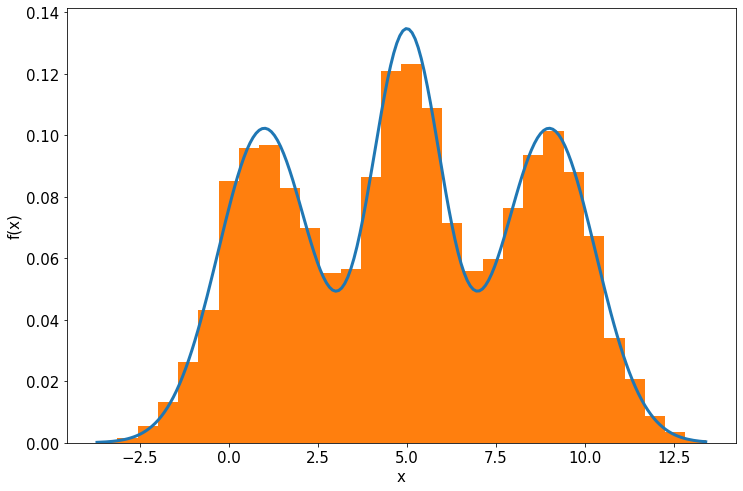

In [28]:
n = 10000
np.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[5, 1],
                        [1, 1.3],
                        [9, 1.3]])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 3.0
# A stream of indices from which to choose the component
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += st.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys)
plt.hist(y, density=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

Важно вспомнить, что такое мощность и консервативность критерия. Мощность - то вероятность отклонить нулевую гипотезу (в данном случае о том, что медианы равны) при истинности альтернативы (медианы не равны). В данном случае достаточно будет проверить только число отклонений нулевой гипотезы, т.к. мы сэмплируем данные с некоторым заданным сдвигом.

На основе кода выше опишем функцию для построения графиков и вывода результата теста Уилкоксона в зависимости от альфа, дельта.

In [94]:
def wil_plot(alphas, deltas):
    result = []
    
    for delta in deltas:
        for alpha in alphas: 
            n = 1000
            np.random.seed(0x5eed)
            norm_params = np.array([[0, 1],
                                    [2, 4]])
            weights = np.array([alpha, (1-alpha)])
            mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
            
            y_1 = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)
            
            y_2 = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64) + delta
    
            result.append((alpha, delta, st.wilcoxon(y_2-y_1)[1]))
            print('p-value = {:.3f}'.format(st.wilcoxon(y_2-y_1)[1]))
            print('delta={}, alpha={}'.format(delta, alpha))
        
            xs_1 = np.linspace(y_1.min(), y_1.max(), 200) 
            ys_1 = np.zeros_like(xs_1)
            xs_2 = np.linspace(y_1.min(), y_1.max(), 200) + delta
            ys = np.zeros_like(xs_2)

            for (l, s), w in zip(norm_params, weights):
                ys += st.norm.pdf(xs_1, loc=l, scale=s) * w
            
            plt.plot(xs_1, ys, label='theory_1')
            plt.plot(xs_2, ys, label='theory_2')
            plt.hist(y_1, density=True, label='sample_1')
            plt.hist(y_2, density=True, label='sample_2')
            plt.xlabel('x')
            plt.ylabel('p(x)')
            plt.legend(loc='best')
            plt.grid()
   
    return result

p-value = 0.000
delta=5, alpha=1


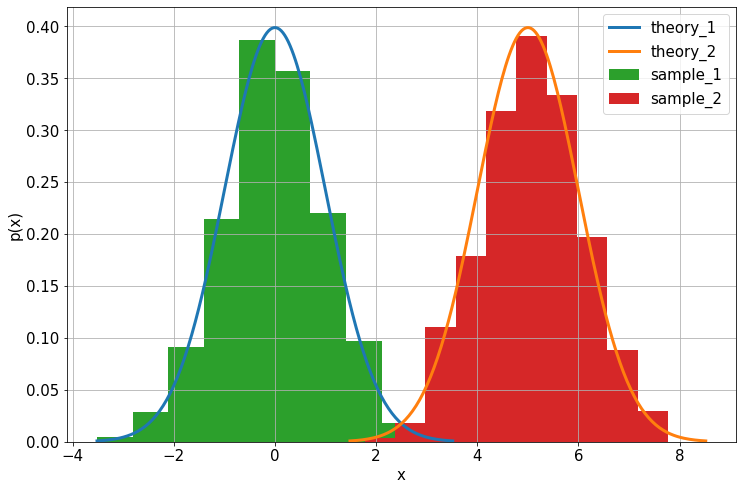

In [95]:
test = wil_plot([1], [5])

p-value = 0.000
delta=5, alpha=0.1


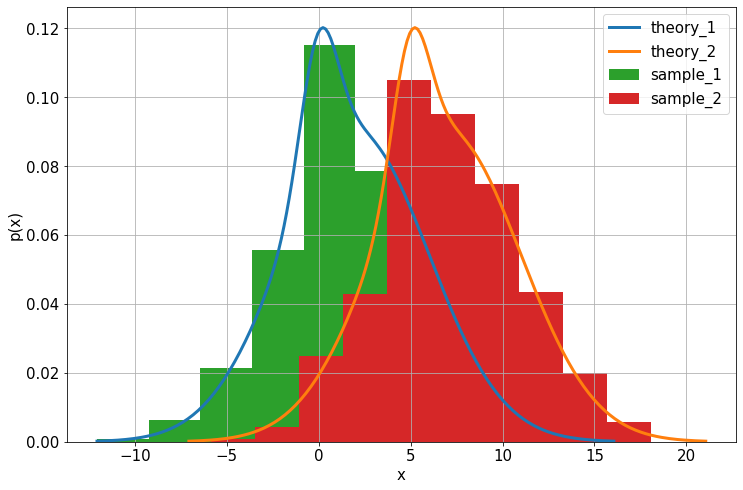

In [96]:
test = wil_plot([0.1], [5])

p-value = 0.074
delta=0.05, alpha=0.5


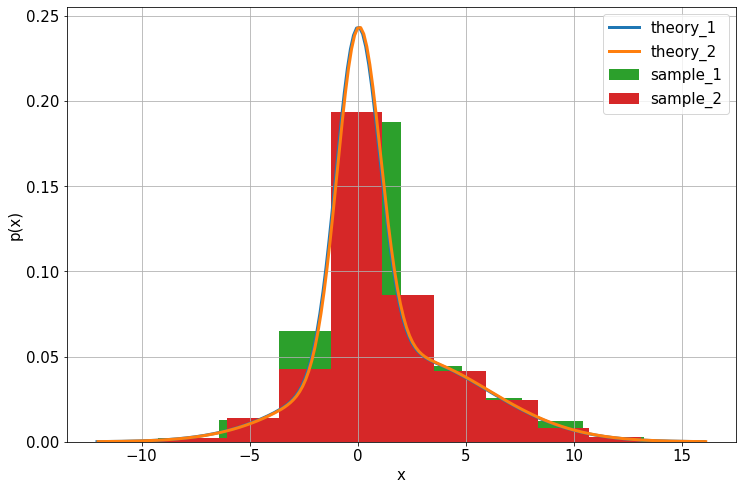

In [97]:
test = wil_plot([.5], [.05])

Видно, что при порядке дельта 0.05, критерий начинает отвергать нулевую гипотезу.

p-value = 0.179
delta=0.005, alpha=0.5
p-value = 0.164
delta=0.01, alpha=0.5
p-value = 0.074
delta=0.05, alpha=0.5
p-value = 0.022
delta=0.1, alpha=0.5
p-value = 0.000
delta=0.5, alpha=0.5
p-value = 0.000
delta=1.0, alpha=0.5


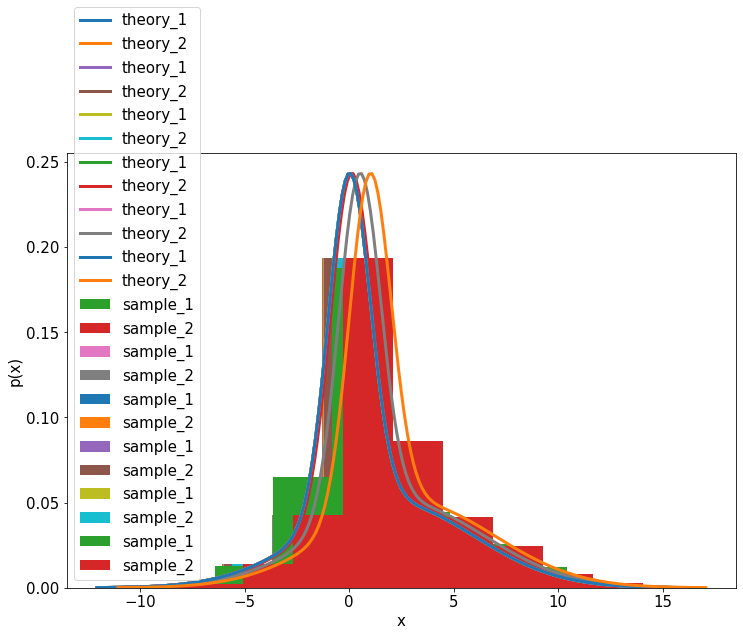

In [98]:
deltas = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
test = wil_plot([0.5], deltas)

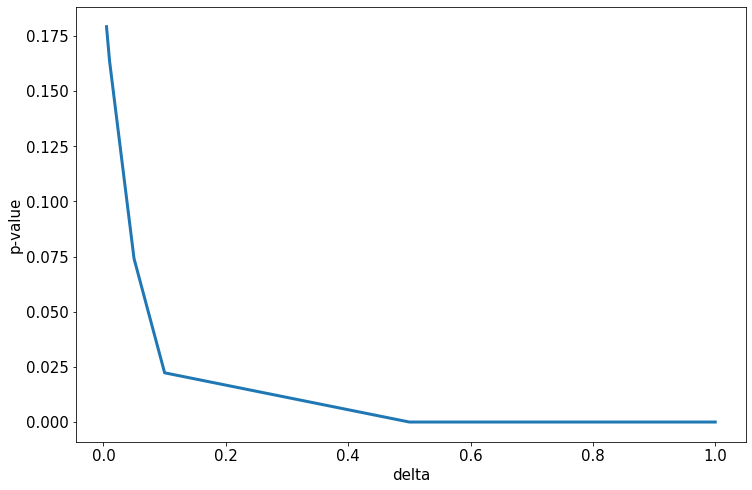

In [102]:
plt.plot([x[1] for x in test], [x[2] for x in test])
plt.xlabel("delta")
plt.ylabel("p-value")
plt.show()

Получаем, что критерий Уилкоксона, действительно, почти всегда различает смеси при дельта, больших 0.05-0.08. В случаях малых дельт, различия он улавливает очень редко. 